Test~~

Start Debugging!!

### Comments and  Import Packages


In [1]:
__author__ = "Lingqing Gan"

"""
File Name: 
exp28-YSP_movariate_add_linear_jupyter_debug.py

Notes 02/03/2020 (exp28):
Use Jupyter notebook to run this code line by line and add plots in order to debug.

Notes 01/29/2020 (exp27):
With the single variable version, we add the estimation of
linear vector a_vect.


Notes 01/28/2020 (exp25):
This is the original code - single variable version.
This is the one that works.
Now the task is to convert it to a more up to date version 
and capable of saving the data. Then we add the estimation of 
vector a.

Add functions to save data.
"""

'\nFile Name: \nexp28-YSP_movariate_add_linear_jupyter_debug.py\n\nNotes 02/03/2020 (exp28):\nUse Jupyter notebook to run this code line by line and add plots in order to debug.\n\nNotes 01/29/2020 (exp27):\nWith the single variable version, we add the estimation of\nlinear vector a_vect.\n\n\nNotes 01/28/2020 (exp25):\nThis is the original code - single variable version.\nThis is the one that works.\nNow the task is to convert it to a more up to date version \nand capable of saving the data. Then we add the estimation of \nvector a.\n\nAdd functions to save data.\n'

In [2]:
# ------------------------------------------------------------------------------------

#   FILE_NAME:      YSP_movariate.py

#   DESCRIPTION:    Gibbs sampling for single variable time series state
#                   transition and precision (variance).
#                   Using Asher's dissertation chapter 2.


#   AUTHOR:         Lingqing Gan (Stony Brook University)

#   DATE:           06/19/2018 - 06/29/2018

# ------------------------------------------------------------------------------------

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t as student
from math import sqrt
from math import log


# packages used to save the data

import time
import pickle
import os
from os.path import join

In [4]:
time_string = time.strftime("%Y%m%d-%H%M%S", time.localtime())


In [5]:
time_string

'20200203-151938'

### Parameters and Data

In [6]:
# data section of the dict to be saved
data_dict = {}
z_e_record = {}
v_e_record = {}
a_vector_e_record = {}

### A few functions

In [7]:
def book_keeping_n(z):

    n = np.array([])
    for i in range(0,len(z)):
        if i == 0:
            n_count = 1
            temp = z[i]
            continue
        elif i < len(z) - 1:
            if z[i] == temp:
                n_count = n_count + 1
            else:
                n = np.append(n,n_count)
                n_count = 1
            temp = z[i]
            continue
        else:
            if z[i] == temp:
                n_count = n_count + 1
                n = np.append(n, n_count)
            else:
                n = np.append(n, n_count)
                n = np.append(n, 1)
            continue

    return n

In [8]:
def book_keeping_z(z):

    flag1 = 0

    flag2 = 0

    for i in range(0, len(z)):
        if z[i] == -10:
            flag1 = 1
            new = i

    for i in range(1, len(z)):
        if z[i] - z[i-1] == 2:
            flag2 = 1
            gap = i

    if flag1 == 1 and flag2 == 0:
        z[new] = z[new-1] + 1

        if new < len(z) - 1 and z[new] == z[new+1]:

            for i in range(new+1,len(z)):
                z[i] = z[i] + 1

    if flag2 == 1 and flag1 == 0:
        for i in range(gap, len(z)):
            z[i] = z[i]-1

    for i in range(0,len(z)-1):
        if z[i+1] > z[i] + 1:
            print("error")
            break

    return z


In [9]:
# hyper parameters

a = 1
b = 1
c = 1
d = 1

T = 300              # length of time series

In [10]:
# hyper parameter for vector a

# length of a vector
a_vect_length = 2

# each element of a vector follows a uniform dist
# on [a_vect_min, a_vect_max]
a_vect_min = -1
a_vect_max = 1

a_vect = np.zeros((T, a_vect_length))          # nparray that saves the true vector data

a_signal_mean = np.zeros(T)

a_vect_e = np.zeros((T, a_vect_length))        # the current estimated value of a vector
                                               # throughout the entire sequence

a_vect_record = {}          # dict to save a_vect_e for each iteration of Gibbs sampling
                            # key: Gibbs iteration; value: nparray of a_vect_e

In [11]:
# ---------------------------------------------------------------------------------------
#
#  generate random signals according to Yule-Simon process
#
# ---------------------------------------------------------------------------------------

### Generate the data

In [12]:

# alpha = np.random.gamma(shape=a,scale=1/b)        # calibration parameter

alpha = 0.75

# variables

s = np.zeros(T)     # indicator of new regime. s[t] = 1 means new regime, s[t] = 0 means continue existing
z = np.zeros(T)     # regime index at [t].
v = np.zeros(T)     # signal precision (lambda) at [t]
x = np.zeros(T)     # signal at [t]


s[0] = 1            # the first node is automatically assigned to the first regime, so new regime indicatior is 1

z[0] = 1            # the first node is automatically assigned to the 1st regime

v[0] = np.random.gamma(shape=c, scale=1/d)     # assign the first precision

a_signal_mean[0] = 0                # the mean value of the given signal
                            # starts from 0

x[0] = np.random.normal(loc=a_signal_mean[0],
                        scale=sqrt(1/v[0]))       # signal

n_count = 1         # number of nodes in the current regime

# randomly generate the values of a_vector for the 1st time slot
for i in range(0, a_vect_length):
    a_vect[0, i] = np.random.uniform(low=a_vect_min,
                                     high=a_vect_max,
                                     size=1)

for t in range(1, T):

    # update value of p (probability of creating new regime)
    p = alpha / (n_count + alpha)

    # if s[t] = 1, then x[t] belongs to a new regime
    s[t] = np.random.binomial(1, p)

    # repeat:
    # n_count:        update the number of nodes in the current regime
    # z:              assign regime number to the t'th node
    # v:              assign precision
    # a_vect:         assign a_vector values
    # a_signal_mean:  the mean value of the new signal
    # x:              assign i.i.d. signal

    if s[t] == 1:
        n_count = 1
        z[t] = z[t - 1] + 1
        v[t] = np.random.gamma(shape=c, scale=1/d)
        for i in range(0, a_vect_length):
            a_vect[t, i] = np.random.uniform(low=a_vect_min,
                                     high=a_vect_max,
                                     size=1)

        a_signal_mean[t] = a_vect[t, 0]
        for i in range(1, a_vect_length):
            if t-i >= 0:
                a_signal_mean[t] += a_vect[t, i] * x[t-i]

        x[t] = np.random.normal(loc=a_signal_mean[t],
                                scale=sqrt(1/v[t]))
    else:
        n_count = n_count + 1
        z[t] = z[t - 1]
        v[t] = v[t - 1]
        for i in range(0, a_vect_length):
            a_vect[t, i] = a_vect[t-1, i]

        a_signal_mean[t] = a_vect[t, 0]
        for i in range(1, a_vect_length):
            if t-i >= 0:
                a_signal_mean[t] += a_vect[t, i] * x[t-i]

        x[t] = np.random.normal(loc=a_signal_mean[t],
                                scale=sqrt(1 / v[t]))


### Visualize the generated data

In [13]:
z

array([ 1.,  1.,  1.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  5.,  6.,  7.,  7.,  8.,  8.,  9., 10., 10., 10., 10., 10.,
       11., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       13., 13., 13., 13., 13., 14., 14., 14., 14., 14., 15., 16., 17.,
       18., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
       19., 19., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 21., 21., 22., 23., 24., 24., 24., 24.,
       24., 24., 24., 25., 25., 25., 26., 27., 28., 29., 29., 29., 29.,
       29., 29., 29., 29., 30., 30., 30., 30., 31., 31., 31., 31

In [14]:
x

array([  0.16890465,  -1.06769621,  -0.42248289,   2.39628704,
        -3.1996576 ,   2.44995797,  -2.74633754,   0.75004437,
        -1.20224736,   2.98592192,  -4.29046138,   5.90800593,
        -2.35976677,   3.0030032 ,  -3.6555662 ,   1.9633217 ,
        -2.09402583,   2.03504636,   1.02744766,  -0.45121831,
        -1.36594314,  -0.72039723,   3.03658821,  -0.48852611,
         2.29330421,  -1.48879898,   0.449291  ,  -1.69551589,
         4.31303172,  -3.16138019,   3.86385702,  -4.69181064,
         3.81465125,  -7.42828436,   9.68376179, -10.43609717,
        10.68880014,  -8.49128791,   9.67064455,  -6.14820996,
         4.55653651,  -6.53688072,   5.66639879,  -6.66042054,
         9.3732719 ,  -6.02525485,   6.98769316,  -7.32469617,
         7.68173169,  -9.29921111,  11.00782836, -10.68824317,
        11.77254999, -11.30368075,  12.27253179,  -9.75216061,
        13.49247758, -11.97771884,  11.49907695, -11.02590306,
         9.40413788,  -8.81103089,   8.9088203 ,  -7.58

In [15]:
a_vect

array([[-8.57558260e-01,  1.65106487e-02],
       [-8.57558260e-01,  1.65106487e-02],
       [-8.57558260e-01,  1.65106487e-02],
       [ 6.14384532e-01, -3.56267489e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.58632626e-01, -9.35074386e-01],
       [ 5.

In [16]:
s

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [17]:
v

array([2.13845547, 2.13845547, 2.13845547, 0.45352805, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.42491713,
       0.42491713, 0.42491713, 0.42491713, 0.42491713, 0.10619044,
       0.10619044, 0.10619044, 0.10619044, 0.10619044, 0.10619044,
       0.10619044, 0.10619044, 0.10619044, 0.10619044, 0.10619

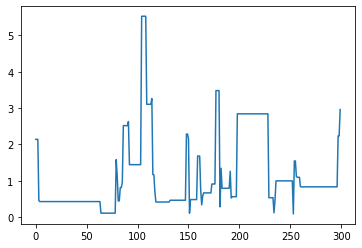

In [18]:
fig1, ax = plt.subplots(1)
ax.plot(range(T), v)

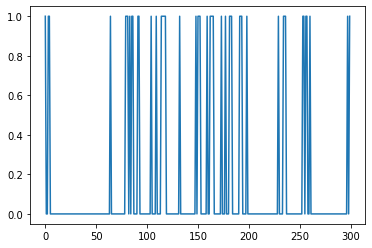

In [19]:
fig2, ax2 = plt.subplots(1)
ax2.plot(range(T), s)

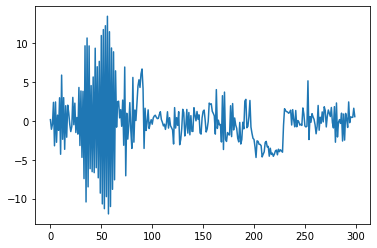

In [20]:
fig3, ax3 = plt.subplots(1)
ax3.plot(range(T), x)

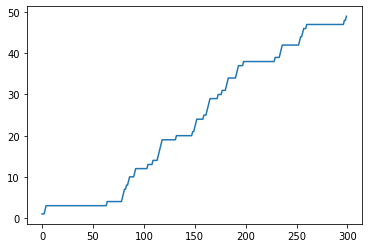

In [21]:
fig4, ax4 = plt.subplots(1)
ax4.plot(range(T), z)

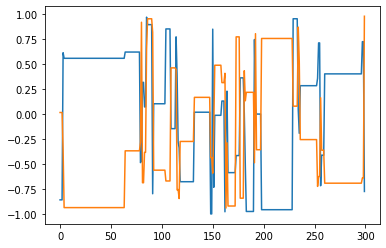

In [22]:
fig4, ax4 = plt.subplots(1)
ax4.plot(range(T), a_vect)

### Now we check Inference

In [23]:
# ---------------------------------------------------------------------------------------
#
#  infer the signals using Gibbs sampling algorithm
#
# ---------------------------------------------------------------------------------------

In [24]:
# ---------------------- #
#  1. initialization     #
# ---------------------- #

In [25]:

# initial estimation values of parameters
alpha_e = 1
a_e = 1
b_e = 1
c_e = 1
d_e = 1

z_e = np.zeros(T)     # inference: indicator of regime index at [t].
v_e = np.zeros(T)     # inference: indicator of variance at [t]
s_e = np.zeros(T)     # inference: indicator of new regime


mean_e = np.zeros(T)     # inference: the estimated mean values of each time instant
                         # initialized as 0

# x_mean_adjusted = x_original_data - mean_e
x_mean_adjusted = x.copy()     # the signal after adjusting for the mean value
x_original_data = x.copy()     # a copy of original x signal as archive

n_count_e = 1         # inference: number of nodes in the current regime

z_e[0] = 0            # (with inference:) the first node is automatically assigned to the 0st regime
s_e[0] = 1

c_e_v = 3/2                       # the values of c_i and d_i are updated on themselves, replacing the previous values

d_e_v = 1 + 0.5 * x[0] ** 2       # c_i and d_i are Gamma parameters to draw precision

v_e[0] = np.random.gamma(shape=c_e, scale=1/d_e)       # draw precision

In [27]:

for t in range(1, T):

    # calculate corresponding prob

    p1 = n_count_e / (n_count_e + alpha_e) * norm.pdf(x_mean_adjusted[t],
                                                      loc=0,
                                                      scale=sqrt(1/v_e[t-1]))

    p2 = alpha_e / (n_count_e + alpha_e) * student.pdf(x_mean_adjusted[t],
                                                       2*c_e,
                                                       loc=0,
                                                       scale=sqrt(d_e/c_e))

    p_temp = p2/(p1+p2)                 # p_temp is the probability that there's a new regime

    # roll the Bernoulli dice
    s_e[t] = np.random.binomial(1, p_temp)      # s_e[t]=1 means new regime

    if s_e[t] == 1:

        # new regime
        # regime index & count
        z_e[t] = z_e[t-1] + 1
        n_count_e = 1

        # draw precision from Gamma distribution
        c_e_v = 3/2
        d_e_v = 1 + 0.5 * x_mean_adjusted[t] ** 2
        v_e[t] = np.random.gamma(shape=c_e_v,
                                 scale=1/d_e_v)

    else:

        # not new regime
        # regime index & count
        z_e[t] = z_e[t-1]
        n_count_e = n_count_e + 1

        # draw precision from Gamma distribution
        c_e_v = c_e_v + 1/2
        d_e_v = d_e_v + 1/2 * x_mean_adjusted[t] ** 2
        v_e[(t-n_count_e+1):(t+1)] = np.random.gamma(shape=c_e_v,
                                                     scale=1/d_e_v)



### Show the initialized values

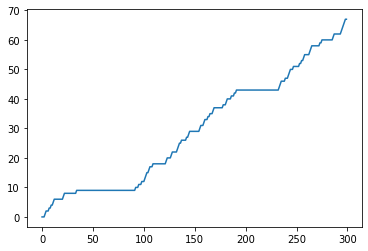

In [28]:
fig4, ax4 = plt.subplots(1)
ax4.plot(range(T), z_e)

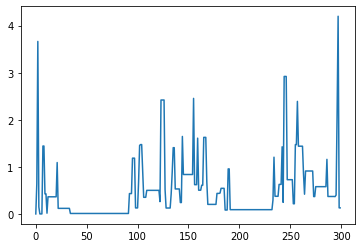

In [29]:
fig4, ax4 = plt.subplots(1)
ax4.plot(range(T), v_e)

In [30]:
# ---------------------- #
#  2.    inference       #
# ---------------------- #

In [31]:

rep = 1000           # rounds of Gibbs sampling
rep_alpha = 1000     # rounds of Gibbs sampler for alpha

alpha_estimate = np.zeros(rep)

regime_count_e = np.zeros(rep)

alpha_e_record = np.zeros(rep)

n_i = book_keeping_n(z_e)

In [32]:
for rep_index in range(0, rep):

    # print progress
    print(rep_index, "/", rep)

    # =====================
    #       draw z_t
    #   (the partitions)
    # =====================
    # (only consider the 2nd till and last node)

    for t in range(1, T-1):

        if z_e[t] == z_e[t-1] and z_e[t] == z_e[t+1]:

            # no boundary then pass
            continue

        elif z_e[t] == z_e[t-1] and z_e[t] != z_e[t+1]:

            # right boundary

            # calculate the probs

            # merge with left (which is equal to remaining the same)
            p_z_1 = (n_i[int(z_e[t])]-1)/(
                    n_i[int(z_e[t])] + alpha_e
                    ) * norm.pdf(x_mean_adjusted[t],
                                 loc=0,
                                 scale=sqrt(1/v_e[t]))

            # merge with right
            p_z_2 = (n_i[int(z_e[t+1])])/(
                    n_i[int(z_e[t+1])] + alpha_e + 1
                    ) * norm.pdf(x_mean_adjusted[t],
                                 loc=0,
                                 scale=sqrt(1/v_e[t+1]))

            # create new regime
            p_z_k = alpha_e / (alpha_e + 1
                               ) * student.pdf(x_mean_adjusted[t],
                                               2*c_e,
                                               loc=0,
                                               scale=sqrt(d_e/c_e))

            sum_temp = p_z_1 + p_z_2 + p_z_k

            # draw
            z_e[t] = np.random.choice([z_e[t], z_e[t+1], -10],
                                      1,
                                      p=[p_z_1/sum_temp,
                                         p_z_2/sum_temp,
                                         p_z_k/sum_temp])

            z_e = book_keeping_z(z_e)
            n_i = book_keeping_n(z_e)

            continue

        elif z_e[t] != z_e[t-1] and z_e[t] == z_e[t+1]:

            # left boundary

            # calculate the probs

            # merge with right (which is equal to remaining the same)
            p_z_1 = (n_i[int(z_e[t])]-1)/(
                    n_i[int(z_e[t])] + alpha_e
                    ) * norm.pdf(x_mean_adjusted[t],
                                 loc=0,
                                 scale=sqrt(1/v_e[t]))

            # merge with left
            p_z_2 = (n_i[int(z_e[t]-1)]
                    )/(n_i[int(z_e[t]-1)] + alpha_e + 1
                    ) * norm.pdf(x_mean_adjusted[t],
                                 loc=0,
                                 scale=sqrt(1/v_e[t-1]))

            # create new regime
            p_z_k = alpha_e / (
                    alpha_e + 1) * student.pdf(x_mean_adjusted[t],
                                               2*c_e,
                                               loc=0,
                                               scale=sqrt(d_e/c_e))

            sum_temp = p_z_1 + p_z_2 + p_z_k

            # draw
            z_e[t] = np.random.choice([z_e[t], z_e[t-1], -10],
                                      1,
                                      p=[p_z_1/sum_temp,
                                         p_z_2/sum_temp,
                                         p_z_k/sum_temp])

            z_e = book_keeping_z(z_e)
            n_i = book_keeping_n(z_e)

            continue

        elif z_e[t] != z_e[t - 1] and z_e[t] != z_e[t + 1]:

            # double boundary

            # calculate the probs

            # merge with left
            p_z_1 = (n_i[int(z_e[t]-1)]) / (
                    n_i[int(z_e[t]-1)] + alpha_e + 1
                    ) * norm.pdf(x_mean_adjusted[t],
                                 loc=0,
                                 scale=sqrt(1 / v_e[t-1]))

            # merge with right
            p_z_2 = (n_i[int(z_e[t] + 1)]) / (
                    n_i[int(z_e[t] + 1)] + alpha_e + 1
                    ) * norm.pdf(x_mean_adjusted[t],
                                 loc=0,
                                 scale=sqrt(1 / v_e[t + 1]))

            # create new regime (which means remaining the same)
            p_z_k = alpha_e / (alpha_e + 1) * student.pdf(
                x_mean_adjusted[t],
                2 * c_e,
                loc=0,
                scale=sqrt(d_e / c_e))

            sum_temp = p_z_1 + p_z_2 + p_z_k

            # draw
            z_e[t] = np.random.choice([z_e[t - 1], z_e[t + 1], z_e[t]],
                                      1,
                                      p=[p_z_1/sum_temp,
                                         p_z_2/sum_temp,
                                         p_z_k/sum_temp])

            z_e = book_keeping_z(z_e)
            n_i = book_keeping_n(z_e)

            continue

    regime_count_e[rep_index] = z_e[-1] + 1

    # =================
    #   draw a vector
    # =================
    for regime_count_index in range(0, int(z_e[-1] + 1)):
        # for each regime:

        # length of current regime
        current_length = n_i[regime_count_index]

        # patch: skip current regime if length is 1
        # 01/29/2020 is this really necessary??
        # yes.
        if current_length == 1:
            # save the a values to the a matrix within this current regime
            for x_index in range(0, len(z_e)):
                if z_e[x_index] == regime_count_index:
                    a_vect_e[x_index, :] = 2
                    break # we can use break here since the length of this
                    # regime is 1 anyway
            continue

        # find absolute index of current regime signals
        signal_absolute_index = []

        # find signals of the current regime
        cur_reg_signals = []
        for x_index in range(0, len(z_e)):
            if z_e[x_index] == regime_count_index:
                cur_reg_signals.append(x[x_index])
                signal_absolute_index.append(x_index)

        cur_reg_signals = np.array(cur_reg_signals)
        signal_absolute_index = np.array(signal_absolute_index)

        # the estimated precision and covariance of the current regime
        # signals
        for x_index in range(0, len(z_e)):
            if z_e[x_index] == regime_count_index:
                current_regime_sig_precision = v_e[x_index]
                break

        # construct the H matrix
        H_mat_height = int(current_length)
        H_mat_width = a_vect_length
        H_mat = np.zeros((H_mat_height, H_mat_width))

        # the absolute index of the first signal of the
        # current regime
        initial_signal_index = signal_absolute_index[0]

        for local_t in range(H_mat_height):
            for coef_index in range(0, a_vect_length):
                # (for each element of H_matrix)
                # fill in H matrix
                if coef_index == 0:
                    # all 1s on first column
                    H_mat[local_t][coef_index] = 1
                else:
                    # the corresponding (absolute) x index for this
                    # location in the matrix is:
                    # initial_signal_index + local_t - coef_index
                    target_x_index = initial_signal_index\
                                     + local_t\
                                     - coef_index
                    if target_x_index >= 0:
                        # only put the x value if index >= 0
                        # cause otherwise the signal doesn't exist
                        H_mat[local_t][
                            coef_index] = x[target_x_index]

        # calculate mean vector
        # print(H_mat)
        square_mat = np.matmul(H_mat.transpose(), H_mat)
        # print(square_mat)
        square_mat_inverse = np.linalg.inv(square_mat)
        mult_temp = np.matmul(square_mat_inverse, H_mat.transpose())
        a_vect_mean = np.matmul(mult_temp, cur_reg_signals)

        # calculate precision matrix for a_vector
        # calculate covariance matrix for a_vector
        a_vect_precision = current_regime_sig_precision**2 * square_mat
        a_vect_covariance = np.linalg.inv(a_vect_precision)

        # generate random a vector
        a_vect_random = np.random.multivariate_normal(mean=a_vect_mean,
                                                 cov=a_vect_covariance)

        # regularize the values of the randomly generated a into the
        # predefined range
        for temp_index in range(len(a_vect_random)):
            if a_vect_random[temp_index] < a_vect_min:
                a_vect_random[temp_index] = a_vect_min
            elif a_vect_random[temp_index] > a_vect_max:
                a_vect_random[temp_index] = a_vect_max

        # save the a vector to the a matrix within this current regime
        for x_index in range(0, len(z_e)):
            if z_e[x_index] == regime_count_index:
                for temp_index in range(0, a_vect_length):
                    a_vect_e[x_index, temp_index] = a_vect_random[temp_index]

    # calculate the mean value sequence given the estimated a_vect_e
    for t in range(1, T):
        if t < a_vect_length:
            # print(t)
            # print(x_original_data[0:t])
            # print(a_vect_e[t, 1:t+1])
            mean_e[t] = sum(
                x_original_data[0:t] * a_vect_e[t, 1:t+1]) + a_vect_e[t, 0]
        else:
            mean_e[t] = sum(
                x_original_data[t-a_vect_length+1:t] * a_vect_e[t, 1:]
                ) + a_vect_e[t, 0]

    # deduct the mean value sequence from the x_original sequence
    x_mean_adjusted = x_original_data - mean_e

    # ================================
    #    draw alpha (Gibbs sampler)
    # ================================
    for rep_alpha_index in range(0, rep_alpha):

        # draw w_j
        # draw alpha

        b_draw_alpha = b_e

        for i in range(0, len(n_i)):

            w = np.random.beta(a=alpha_e+1,
                               b=n_i[i],
                               size=1)

            b_draw_alpha = b_draw_alpha - log(w)

        a_draw_alpha = a_e + len(n_i)

        alpha_e = np.random.gamma(shape=a_draw_alpha,
                                  scale=1 / b_draw_alpha)

        alpha_estimate[rep_alpha_index] = alpha_e

    alpha_e_record[rep_index] = alpha_e

    # ================================
    #        draw v_e[0:T-1]
    # ================================

    for i in range(0, len(n_i)):

        d_e_v = d_e

        c_e_v = c_e + n_i[i] / 2

        for j in range(0, len(z_e)):

            if z_e[j] == i:

                d_e_v = d_e_v + 1/2 * x_mean_adjusted[j] ** 2

        v_i = np.random.gamma(shape=c_e_v,
                              scale=1/d_e_v)

        for j in range(0, len(z_e)):

            if z_e[j] == i:

                v_e[j] = v_i

    z_e_record[rep_index] = z_e.copy()
    v_e_record[rep_index] = v_e.copy()
    a_vector_e_record[rep_index] = a_vect_e.copy()
    
    
    


0 / 1000
1 / 1000
2 / 1000
3 / 1000
4 / 1000
5 / 1000
6 / 1000
7 / 1000
8 / 1000
9 / 1000
10 / 1000
11 / 1000
12 / 1000
13 / 1000
14 / 1000
15 / 1000
16 / 1000
17 / 1000
18 / 1000
19 / 1000
20 / 1000
21 / 1000
22 / 1000
23 / 1000
24 / 1000
25 / 1000
26 / 1000
27 / 1000
28 / 1000
29 / 1000
30 / 1000
31 / 1000
32 / 1000
33 / 1000
34 / 1000
35 / 1000
36 / 1000
37 / 1000
38 / 1000
39 / 1000
40 / 1000
41 / 1000
42 / 1000
43 / 1000
44 / 1000
45 / 1000
46 / 1000
47 / 1000
48 / 1000
49 / 1000
50 / 1000
51 / 1000
52 / 1000
53 / 1000
54 / 1000
55 / 1000
56 / 1000
57 / 1000
58 / 1000
59 / 1000
60 / 1000
61 / 1000
62 / 1000
63 / 1000
64 / 1000
65 / 1000
66 / 1000
67 / 1000
68 / 1000
69 / 1000
70 / 1000
71 / 1000
72 / 1000
73 / 1000
74 / 1000
75 / 1000
76 / 1000
77 / 1000
78 / 1000
79 / 1000
80 / 1000
81 / 1000
82 / 1000
83 / 1000
84 / 1000
85 / 1000
86 / 1000
87 / 1000
88 / 1000
89 / 1000
90 / 1000
91 / 1000
92 / 1000
93 / 1000
94 / 1000
95 / 1000
96 / 1000
97 / 1000
98 / 1000
99 / 1000
100 / 1000

755 / 1000
756 / 1000
757 / 1000
758 / 1000
759 / 1000
760 / 1000
761 / 1000
762 / 1000
763 / 1000
764 / 1000
765 / 1000
766 / 1000
767 / 1000
768 / 1000
769 / 1000
770 / 1000
771 / 1000
772 / 1000
773 / 1000
774 / 1000
775 / 1000
776 / 1000
777 / 1000
778 / 1000
779 / 1000
780 / 1000
781 / 1000
782 / 1000
783 / 1000
784 / 1000
785 / 1000
786 / 1000
787 / 1000
788 / 1000
789 / 1000
790 / 1000
791 / 1000
792 / 1000
793 / 1000
794 / 1000
795 / 1000
796 / 1000
797 / 1000
798 / 1000
799 / 1000
800 / 1000
801 / 1000
802 / 1000
803 / 1000
804 / 1000
805 / 1000
806 / 1000
807 / 1000
808 / 1000
809 / 1000
810 / 1000
811 / 1000
812 / 1000
813 / 1000
814 / 1000
815 / 1000
816 / 1000
817 / 1000
818 / 1000
819 / 1000
820 / 1000
821 / 1000
822 / 1000
823 / 1000
824 / 1000
825 / 1000
826 / 1000
827 / 1000
828 / 1000
829 / 1000
830 / 1000
831 / 1000
832 / 1000
833 / 1000
834 / 1000
835 / 1000
836 / 1000
837 / 1000
838 / 1000
839 / 1000
840 / 1000
841 / 1000
842 / 1000
843 / 1000
844 / 1000
845 / 1000

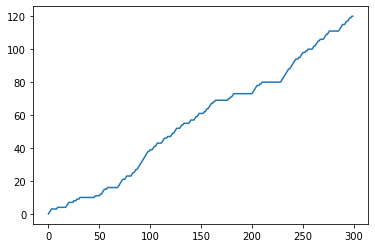

In [33]:
fig4, ax4 = plt.subplots(1)
ax4.plot(range(T), z_e)

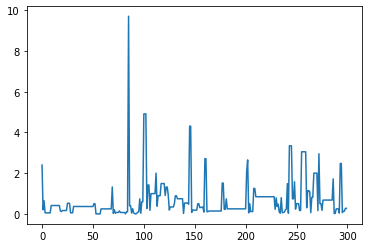

In [34]:
fig1, ax = plt.subplots(1)
ax.plot(range(T), v_e)

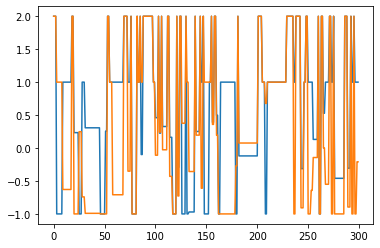

In [35]:
fig1, ax = plt.subplots(1)
ax.plot(range(T), a_vect_e)

In [36]:
print(alpha_e)

1.1719124893561292
